In [59]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, recall_score, accuracy_score, precision_score, f1_score, roc_auc_score
from sklearn.multioutput import MultiOutputClassifier

import xgboost as xgb

# Next two only necessary if target classes are imbalanced
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

pd.set_option("display.max_columns", 50)
%matplotlib inline

random_state = 1232022
model_scoring_dict = {}

In [60]:
X = pd.read_csv('data/training_set_features.csv', index_col='respondent_id')
y = pd.read_csv('data/training_set_labels.csv', index_col='respondent_id')

df = pd.concat([X, y], axis=1)

X_test_comp = pd.read_csv('data/test_set_features.csv', index_col='respondent_id')

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y['h1n1_vaccine'], random_state=random_state)
y_train_h1n1 = y_train.iloc[:,0]
y_train_ssnl = y_train.iloc[:,1]

y_test_h1n1 = y_test.iloc[:,0]
y_test_ssnl = y_test.iloc[:,1]
# Without this cell, a number of future cells will produce a SettingWithCopyWarning
X_train = X_train.copy()
X_test = X_test.copy()
y_train_h1n1 = y_train_h1n1.copy()
y_train_ssnl = y_train_ssnl.copy()
y_test_h1n1 = y_test_h1n1.copy()
y_test_ssnl = y_test_ssnl.copy()
numeric_columns = list(X_train.columns[X_train.dtypes == 'float64'].values)
obj_columns = list(X_train.columns[X_train.dtypes == 'object'].values)
all_columns = list(X_train.columns.values)

In [62]:
def impute_unk(df):
    df.loc[df['employment_industry'].isna(), 'employment_industry'] = 'unknown'
    df.loc[df['employment_occupation'].isna(), 'employment_occupation'] = 'unknown'
    df.loc[df['health_insurance'].isna(), 'health_insurance'] = 2
    
    for column in df:
        if df[column].isnull().any():
            df[column]=df[column].fillna(df[column].mode()[0])
def ord_encode(df):
    
    """
    This function takes a dataframe and encodes some of the
    categorical variables as ordinal, according to a pre-defined
    list of values. This operation is in place.
    """

    df = pd.DataFrame(df)
    
    age_group_values = ['18 - 34 Years', '35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years']
    education_values = ['< 12 Years', '12 Years', 'Some College', 'College Graduate']
    income_poverty_values = ['Below Poverty', '<= $75,000, Above Poverty', '> $75,000']

    values_dict = {'age_group': age_group_values, 'education': education_values, 'income_poverty': income_poverty_values}

    for column_name, values_list in values_dict.items():    
        for num, value in enumerate(values_list):
            df.loc[df[column_name] == value, column_name] = int(num)
        df[column_name] = df[column_name].astype(int)
def clean(df):
    impute_unk(df)
    ord_encode(df)

In [63]:
def train_new_model(estimator, preprocessor, grid=None, model_name=['H1N1', 'Seasonal Flu'], keep_score=False, suppress_output=False):
    """
    This function takes in a tuned estimator as well as a choice of a preprocessor
    and returns a number of scoring metrics. It also saves the model and it's
    results in a scoring dictionary. It can alternatively do a grid search if passed
    a grid list. Scoring output can be suppressed with suppress_output=True.
    
    Note: The grid search feature is not yet functional.
    
    estimator: the class of the regressor or classifier to be modeled. Any desired
    hyperparameters should be included (e.g. LogisticRegression(max_iter=1000)).
    
    preprocessor: string - 'linear' or 'tree'
    
    grid: a list of hyperparameters with which do do a grid search
    
    suppress_output: bool
    """
    
    ohe_transform = ColumnTransformer(
        transformers=[
            ('ohe', OneHotEncoder(handle_unknown="ignore", sparse=False), all_columns)])
        
    linear_preprocessor = Pipeline(
        steps=[
            ('ohe', ohe_transform),
            ('est', estimator)
        ])
        
    tree_transformer = ColumnTransformer(
        transformers=[
            ('minmax', MinMaxScaler(), numeric_columns),
            ('ohe', OneHotEncoder(handle_unknown="ignore", sparse=False), obj_columns)
        ])
        
    tree_preprocessor = Pipeline(
        steps=[
            ('tree', tree_transformer),
            ('est', estimator)
        ])
    
    if grid:
        pass
    
    else:
        
        global y_hat_h1n1
        global y_proba_h1n1
        global y_proba_h1n1_comp
        global y_hat_ssnl
        global y_proba_ssnl
        global y_proba_ssnl_comp
        
        global models_dict
        
        if preprocessor == 'linear':
            pipe = linear_preprocessor
        elif preprocessor == 'tree':
            pipe = tree_preprocessor
        
        def create_entry(i):
            
            dictionary_entry = {'estimator': None, 
                                'preprocessor': None, 
                                'fitted_estimator': None, 
                                'scores': None,
                                'time_run': None
                               }
            
            dictionary_entry['estimator'] = estimator
            dictionary_entry['preprocessor'] = preprocessor
            dictionary_entry['fitted_estimator'] = fitted_estimator
            dictionary_entry['time_run'] = time.asctime()
            models_dict[model_name[i]] = dictionary_entry
        
        clean(X_train)
        clean(X_test)
        clean(X_test_comp)
        
        fitted_estimator = pipe.fit(X_train, y_train_h1n1)
        y_hat_h1n1 = pipe.predict(X_test)
        y_proba_h1n1 = pipe.predict_proba(X_test)
        y_proba_h1n1_comp = pipe.predict_proba(X_test_comp)
        
        if keep_score:
            create_entry(0)

        fitted_estimator = pipe.fit(X_train, y_train_ssnl)
        y_hat_ssnl = pipe.predict(X_test)
        y_proba_ssnl = pipe.predict_proba(X_test)
        y_proba_ssnl_comp = pipe.predict_proba(X_test_comp)
        
        if keep_score:
            create_entry(1)
            
        all_metrics([y_test_h1n1, y_test_ssnl], [y_hat_h1n1, y_hat_ssnl], [y_proba_h1n1, y_proba_ssnl], model_name=model_name, keep_score=keep_score, suppress_output=suppress_output)

In [64]:
def all_metrics(y_actuals, y_hats, y_score=None, model_name=None, keep_score=False, save_fig=False, suppress_output=False):
    """
    This function takes in y_data either as single dataframes or in groups
    as lists and returns recall, precision, accuracy, and f1 score. 
    If y_score is provided, an AUC score will also be calculated.
    If a name for the model is supplied and keep_score is set to True,
    that name along with scores are stored in a model dictionary for later use. 
    
    y_actuals: array/dataframe or a list of arrays/dataframes
    
    y_hats: if y_actuals is list, then list of same length. if 
    y_actuals is single array/dataframe, then single array/dataframe.
    
    y_score: if y_actuals is list, then list of same length. if 
    y_actuals is single array/dataframe, then single array/dataframe.
    
    model_name: string or list of strings. If y_actuals is 
    single array/dataframe, then string. If y_actuals is list, then
    list of same length.
    
    keep_score: bool, saves scores in a score dictionary
    
    save_fig: bool, exports graph to graph folder
    
    suppress_output, bool, if True, scores the model and can additionally
    save scores but does not output any graphs or scoring metrics
    
    Note: save_fig is only supported for single models.
    
    """
    global model_scoring_dict
    global models_dict

    if type(y_actuals) == list:
        if len(y_actuals) != len(y_hats):
            print('The size of each list for y_tests and y_hats needs to be the same size.')
            return
        elif model_name and len(y_actuals) != len(model_name):
            print('The number of names does not match the number of models.')
            return
        else:
            all_scores = {}
            confusion_matrices = []
            for i in list(range(len(y_actuals))):
                y_actual = y_actuals[i]
                y_hat = y_hats[i]
                model_scores = {}
                cf_matrix = confusion_matrix(y_actual, y_hat)
                model_scores['recall'] = recall_score(y_actual, y_hat)
                model_scores['precision'] = precision_score(y_actual, y_hat)
                model_scores['accuracy'] = accuracy_score(y_actual, y_hat)
                model_scores['f1'] = f1_score(y_actual, y_hat)
                if y_score:
                    model_scores['AUC'] = roc_auc_score(y_actual, y_score[i][:,1])
                
                if model_name:
                    all_scores[model_name[i]] = model_scores
                    if keep_score:
                        model_scoring_dict[model_name[i]] = model_scores
                        models_dict[model_name[i]]['scores'] = model_scoring_dict[model_name[i]]
            
                else:
                    all_scores[f'model number {i+1}'] = model_scores
                    
                confusion_matrices.append(cf_matrix)
        
        if keep_score:
            competition_score_csv()
            
            with open('data/models_dict.pickle', 'wb') as f:
                pickle.dump(models_dict, f)
            with open('data/model_scoring_dict.pickle', 'wb') as f:
                pickle.dump(model_scoring_dict, f)
        
        if suppress_output:
            return
        
        row = len(all_scores) // 3
        col = len(all_scores) % 3
        
        if len(all_scores) < 4:
            ncols=len(all_scores)
            nrows=1
        else:
            ncols=3
            if col != 0:
                nrows=row+1
            else:
                nrows=row
                
        sns.set_context('talk')
        fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)
        
        for i, model in zip(range(len(all_scores)), all_scores):
            group_names = ['True Neg','False Pos','False Neg','True Pos']
            categories = ['No vaccine', 'Vaccine']

            group_counts = ['{0:0.0f}'.format(value) for value in confusion_matrices[i].flatten()]
            labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
            labels = np.asarray(labels).reshape(2,2)

            row = i // 3
            col = i % 3
            
            if nrows < 2:
                ax = axes[col]
            else:
                ax = axes[row][col]
            sns.heatmap(cf_matrix, annot=labels, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax)
            ax.set_ylabel('Actual')
            ax.set_yticklabels(ax.get_yticklabels(), va="center")
            ax.set_xlabel('Predicted')
        
            if model_name:
                ax.set_title(model_name[i])
            else:
                ax.set_title('Model Performance')
                
        plt.tight_layout()        

        
        for model in all_scores:
            print('Recall for {}:    {}'.format(model, all_scores[model]['recall']))
        print('')
        for model in all_scores:
            print('Precision for {}: {}'.format(model, all_scores[model]['precision']))
        print('')
        for model in all_scores:
            print('Accuracy for {}:  {}'.format(model, all_scores[model]['accuracy']))
        print('')
        for model in all_scores:
            print('F1 score for {}:  {}'.format(model, all_scores[model]['f1']))
        if y_score:
            print('')
            for model in all_scores:
                print('AUROC for {}:     {}'.format(model, all_scores[model]['AUC']))
            
    else:
        if model_name and type(model_name) != str:
            print('There should only be one model name, and it should be a string.')
            return
        else:
            all_scores = {}
            model_scores = {}
            cf_matrix = confusion_matrix(y_actuals, y_hats)
            model_scores['recall'] = recall_score(y_actuals, y_hats)
            model_scores['precision'] = precision_score(y_actuals, y_hats)
            model_scores['accuracy'] = accuracy_score(y_actuals, y_hats)
            model_scores['f1'] = f1_score(y_actuals, y_hats)
            if y_score is not None:
                model_scores['AUC'] = roc_auc_score(y_actuals, y_score[:,1])
                
            if model_name:
                if keep_score:
                    model_scoring_dict[model_name] = model_scores
                    models_dict[model_name]['scores'] = model_scoring_dict[model_name]

            else:
                all_scores['model'] = model_scores
        
        if keep_score:
            competition_score_csv()
            
            with open('data/models_dict.pickle', 'wb') as f:
                pickle.dump(models_dict, f)
            with open('data/model_scoring_dict.pickle', 'wb') as f:
                pickle.dump(model_scoring_dict, f)
        
        if suppress_output:
            return
        
        cf_matrix = confusion_matrix(y_actuals, y_hats)
        group_names = ['True Neg','False Pos','False Neg','True Pos']
        categories = ['No vaccine', 'Vaccine']

        group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
        labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
        labels = np.asarray(labels).reshape(2,2)

        sns.set_context('talk')
        fig, ax = plt.subplots(figsize=(8,6))

        sns.heatmap(cf_matrix, annot=labels, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax)
        ax.set_ylabel('Actual')
        ax.set_yticklabels(ax.get_yticklabels(), va="center")
        ax.set_xlabel('Predicted')
        if model_name:
            ax.set_title(model_name)
        else:
            ax.set_title('Model Performance')
        
        if save_fig:
            fig.savefig('./graphs/{}'.format(model_name if model_name else 'rename_me'), dpi=300, transparent=False, bbox_inches='tight');
        
        print('Recall:    {}'.format(model_scores['recall']))
        print('Precision: {}'.format(model_scores['precision']))
        print('Accuracy:  {}'.format(model_scores['accuracy']))
        print('F1 score:  {}'.format(model_scores['f1']))
        if y_score is not None:
            print('AUROC:     {}'.format(model_scores['AUC']))

In [65]:
def competition_score_csv():
    
    now = datetime.datetime.now()

    date_time_string = str(now.month) + str(now.day) + str(now.year) + str(now.hour) + str(now.minute) + str(now.second)
    
    submission_df = pd.read_csv('data/submission_format.csv', index_col="respondent_id")
    
    if np.testing.assert_array_equal(X_test_comp.index.values, submission_df.index.values) == False:
        return
    
    submission_df["h1n1_vaccine"] = y_proba_h1n1_comp[:, 1]
    submission_df["seasonal_vaccine"] = y_proba_ssnl_comp[:, 1]
    
    submission_df.to_csv(f'data/comp_submissions/my_submission{date_time_string}.csv', index=True)
    
    return submission_df.head()

# Naive Bayes

In [21]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
gnb = GaussianNB()

Recall for H1N1:    0.6819383259911894
Recall for Seasonal Flu:    0.7668686868686869

Precision for H1N1: 0.3773768893222818
Precision for Seasonal Flu: 0.6112721417069243

Accuracy for H1N1:  0.693373268438787
Accuracy for Seasonal Flu:  0.6660426806439536

F1 score for H1N1:  0.4858757062146893
F1 score for Seasonal Flu:  0.6802867383512544

AUROC for H1N1:     0.723340687693785
AUROC for Seasonal Flu:     0.7461691910383923


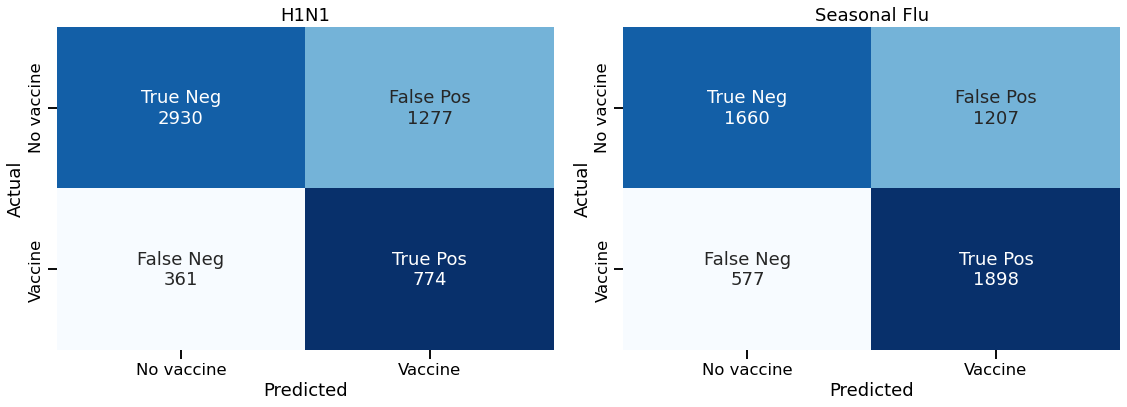

In [22]:
train_new_model(gnb, 'tree')

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   14.0s finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   18.5s finished


Recall for H1N1:    0.373568281938326
Recall for Seasonal Flu:    0.816969696969697

Precision for H1N1: 0.6300148588410104
Precision for Seasonal Flu: 0.6569200779727096

Accuracy for H1N1:  0.8202920254586298
Accuracy for Seasonal Flu:  0.7175215275177836

F1 score for H1N1:  0.4690265486725664
F1 score for Seasonal Flu:  0.7282549972987575

AUROC for H1N1:     0.8001746616976739
AUROC for Seasonal Flu:     0.8052206755380804


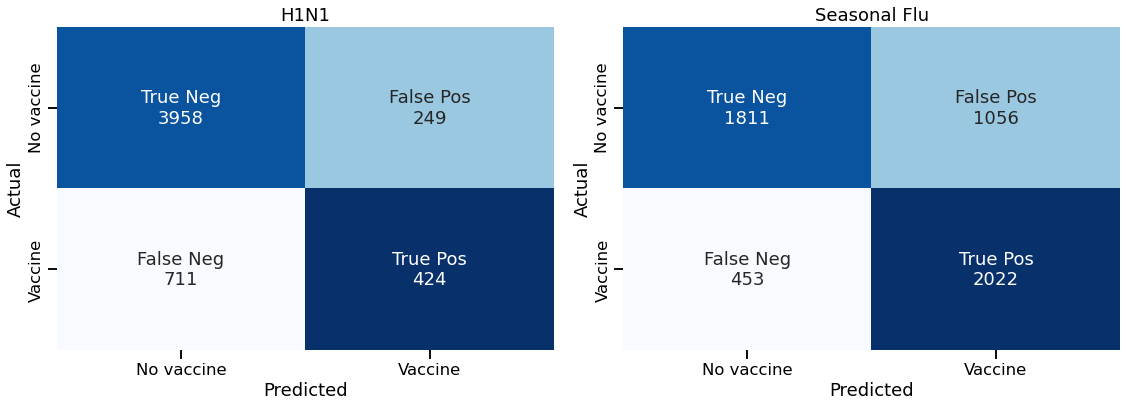

In [27]:
#Run a Grid Search to determine best hyperparameter for the Gaussian Naive Bayes model
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gs_NB = GridSearchCV(estimator=gnb, 
                 param_grid=params_NB, 
                 cv=3,   
                 verbose=1, 
                 scoring='accuracy') 
train_new_model(gs_NB, 'tree')
# gs_NB.best_params_

In [28]:
gs_NB.best_params_

{'var_smoothing': 1.0}

In [49]:
import time
import datetime
import pickle

In [66]:
models_dict = {}

# Best H1N1 Interpretation

Recall for H1N1:    0.4211453744493392
Recall for Seasonal Flu:    0.7486868686868687

Precision for H1N1: 0.7823240589198036
Precision for Seasonal Flu: 0.7647544366487825

Accuracy for H1N1:  0.8521153126169974
Accuracy for Seasonal Flu:  0.7768625982777986

F1 score for H1N1:  0.547537227949599
F1 score for Seasonal Flu:  0.7566353613719886

AUROC for H1N1:     0.8641594824652431
AUROC for Seasonal Flu:     0.8513386392702751


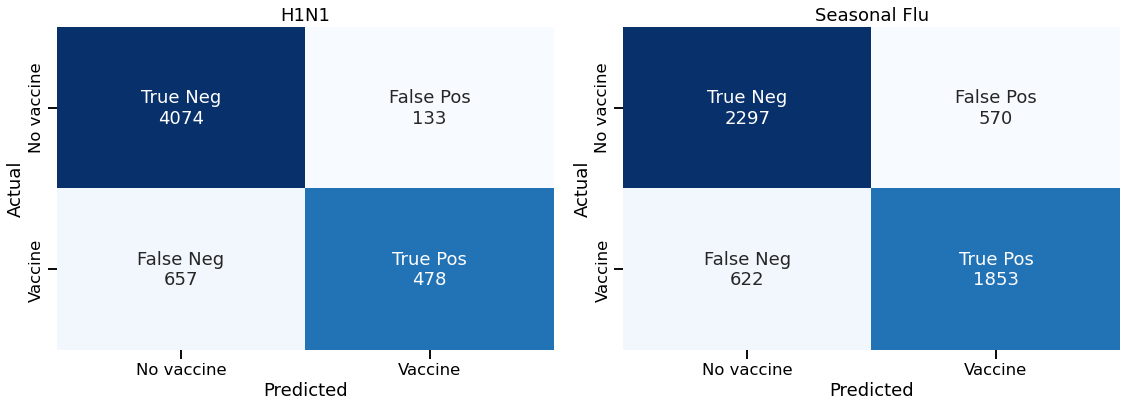

In [67]:
train_new_model(RandomForestClassifier(criterion='gini', max_depth=20, min_samples_leaf=2, min_samples_split=4), 'tree', keep_score=True)

In [14]:
import eli5
from eli5.sklearn import PermutationImportance

In [43]:
models_dict

NameError: name 'models_dict' is not defined

In [68]:
best_forest = models_dict['H1N1']['fitted_estimator']
best_forest

Pipeline(steps=[('tree',
                 ColumnTransformer(transformers=[('minmax', MinMaxScaler(),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'doctor_recc_h1n1',
                                                   'doctor_recc_seasonal',
                                                   'chronic_med_con...
    

In [70]:
perm = PermutationImportance(best_forest, random_state=42).fit(X_test, y_test_h1n1)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

ValueError: could not convert string to float: 'White'

In [27]:
best_forest = RandomForestClassifier(criterion='gini', max_depth=20, min_samples_leaf=2, min_samples_split=4)

best_forest.fit(X_train_dummied, y_train_h1n1)

ValueError: could not convert string to float: 'White'